## 1.Nhập thư viện

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def reset_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

RANDOM_STATE = 42
reset_seed(RANDOM_STATE)


2025-10-27 00:03:19.825682: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 00:03:19.850042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.Tiền xử lý bộ dữ liệu

**Chạy code và trả lời các câu hỏi sau:**
## **AIO25M05GA06**
Cá thể mục tiêu có kích thước bao nhiêu?

A. 487

D. 874

C. 847

D. 784

## **AIO25M05GA07**
Chọn câu trả lời chính xác nhất, các giá trị bên trong của một cá thể (đã được chuẩn hóa) thuộc ...

A. {0, 1}

B. [0, 255]

C. Số nguyên

D. Số thực

## **AIO25M05GA08**
Cá thể mục tiêu là hình ảnh của số?

A. 0

B. 3

C. 5

D. 7

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Kích thước của cá thể: 784
5 giá trị ngẫu nhiên của cá thể trên: [0.    0.    0.224 0.482 0.871]


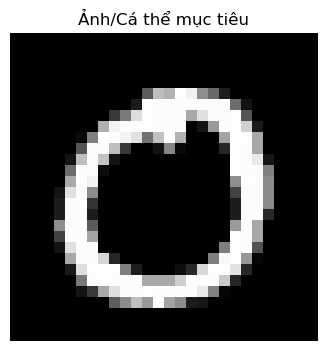

In [3]:
# Tải bộ dữ liệu MNIST: (X_train, y_train), (X_test, y_test), chỉ cần tập train
(X_train, _), (_, _) = mnist.load_data()

# X có shape (N, 28, 28), và miền giá trị thuộc [0,255] -> chuẩn hoá về [0,1]
X_train = X_train / 255.0

# Chọn một ảnh làm mục tiêu
target_img = X_train[206]

target_vec = target_img.flatten()
CHROM_SIZE = target_vec.size
print("Kích thước của cá thể:", CHROM_SIZE)
print("5 giá trị ngẫu nhiên của cá thể trên:", np.round(target_vec[203:208], 3))

# Hiển thị ảnh mục tiêu
plt.figure(figsize=(4,4))
plt.imshow(target_img, cmap='gray')
plt.title(f'Ảnh/Cá thể mục tiêu')
plt.axis('off')
plt.show()

## 3.Định nghĩa các hàm cần thiết
**Xem qua các hàm GA cần thiết.**<br>
**Lưu ý: KHÔNG thay đổi các tham số đã được cấu hình mặc định.**

In [4]:
def mse_loss(vec, target):
    """
    Tính mất mát MSE giữa cá thể đang xét và cá thể mục tiêu.
    Tham số:
        vec: cá thể GA.
        target: cá thể mục tiêu.
    Trả về:
        Giá trị MSE.
    """
    return np.mean((vec - target) ** 2)

def fitness_from_mse(mse):
    """
    Chuyển đổi MSE sang fitness (fitness càng cao càng tốt).
    Tham số:
        mse: giá trị mất mát trung bình bình phương.
    Trả về:
        -MSE.
    """
    return -mse

def init_population(pop_size, chrom_size, low=0, high=1):
    """
    Khởi tạo quần thể ban đầu với các cá thể ngẫu nhiên trong khoảng giá trị cho phép.
    Tham số:
        pop_size: số lượng cá thể trong quần thể.
        chrom_size: số gene trên mỗi cá thể (số chiều).
        low: giá trị biên dưới cho từng gene.
        high: giá trị biên trên cho từng gene.
    Trả về:
        Quần thể ban đầu.
    """
    return np.random.uniform(low, high, size=(pop_size, chrom_size))

def tournament_select(pop, fitnesses, tournament_size=3):
    """
    Chọn một cá thể thông qua giải đấu ngẫu nhiên kích thước k.
    Tham số:
        pop: quần thể hiện tại.
        fitnesses: mảng fitness tương ứng cho từng cá thể.
        tournament_size: số cá thể tham gia mỗi lượt giải đấu.
    Trả về:
        Cá thể thắng cuộc.
    """
    n = len(pop)
    cand_idx = np.random.choice(n, size=tournament_size, replace=True)
    best_local = cand_idx[np.argmax(fitnesses[cand_idx])]
    return pop[best_local].copy()

def uniform_crossover(p1, p2, cx_rate=0.9, indpb=0.5):
    """
    Thực hiện lai ghép đồng đều giữa hai cha mẹ.
    Tham số:
        p1, p2: hai cá thể cha mẹ.
        cx_rate: xác suất thực hiện lai ghép.
        indpb: xác suất độc lập để mỗi gene được hoán đổi giữa hai cha mẹ.
    Trả về:
        Hai cá thể con được lai ghép.
    """
    if np.random.rand() < cx_rate:
        mask = np.random.rand(p1.shape[0]) < indpb
        c1 = p1.copy(); c2 = p2.copy()
        c1[mask] = p2[mask]
        c2[mask] = p1[mask]
        return c1, c2
    return p1.copy(), p2.copy()

def gaussian_mutation(theta, mut_rate=0.2, indpb=0.1, mu=0, sigma=0.01, low=0, high=1):
    """
    Đột biến Gaussian trên từng gene với xác suất mut_rate.
    Tham số:
        theta: cá thể cần đột biến.
        mut_rate: xác suất đột biến cho mỗi gene.
        indpb: xác suất đột biến cho mỗi gene.
        mu: giá trị trung bình của nhiễu Gaussian.
        sigma: độ lệch chuẩn của nhiễu Gaussian.
        low, high: biên dưới và trên để cắt giá trị hợp lệ.
    Trả về:
        Cá thể mới sau đột biến.
    """
    if np.random.rand() < mut_rate:
        mask = np.random.rand(theta.shape[0]) < indpb
        noise = np.random.randn(theta.shape[0]) * sigma + mu
        out = theta.copy()
        out[mask] = out[mask] + noise[mask]
        return np.clip(out, low, high)
    return theta.copy()


In [5]:
# Các hàm hỗ trợ vẽ hình

def vec_to_img(vec):
    """
    Bạn có thể hiểu hàm này như blackbox để chuyển một cá thể thành 1 hình ảnh.

    Chuyển vector 1 chiều (784 phần tử) thành ảnh 2D 28x28 để phục vụ hiển thị.
    Tham số:
        vec: vector 1 chiều chứa các giá trị pixel.
    Trả về:
        Ma trận 2 chiều kích thước (28, 28).
    """
    return vec.reshape(28, 28)

def plot_generation_snapshot(gen, target_img, best_vec):
    """
    Vẽ ảnh mục tiêu, ảnh tái tạo ở một thế hệ cụ thể.
    Tham số:
        gen: chỉ số thế hệ hiện tại.
        target_img: ảnh mục tiêu dạng 2D đã chuẩn hoá.
        best_vec: cá thể dạng vector tốt nhất ở thế hệ gen.
    Trả về:
        None. Hàm hiển thị trực tiếp biểu đồ bằng Matplotlib.
    """
    recon_img = vec_to_img(best_vec)
    _ = np.flip(X_train[3], axis=1)
    diff_img = recon_img + _

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(target_img, cmap='gray')
    axes[0].set_title('Ảnh mục tiêu')
    axes[0].axis('off')

    axes[1].imshow(recon_img, cmap='gray')
    axes[1].set_title(f'Ảnh tái tạo (Gen {gen})')
    axes[1].axis('off')

    axes[2].imshow(diff_img, cmap='gray')
    axes[2].set_title('AIO25M05GA09')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


## 4.Cài đặt cấu hình

In [6]:
pop_size = 32
generations = 4000
elitism = 2

# Các giá trị như kích thước giải đấu, xác suất crossover, mutation, ... đã được cài mặc định trong các hàm trên và không cần thay đổi

## 5.Quy trình tiến hóa

**Hoàn thiện vòng lặp tiến hóa cho đoạn code bên dưới và trả lời câu hỏi sau:**

## **AIO25M05GA09**
Xem biểu đồ trực quan quá trình tiến hóa/tái tạo ảnh, `AIO25M05GA09` có hình gì?

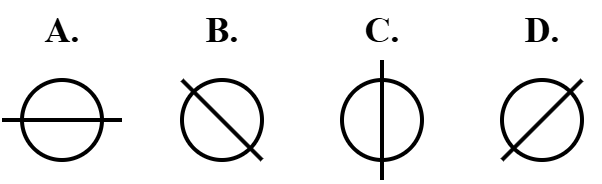

Gen 0 | Best MSE = 0.28683


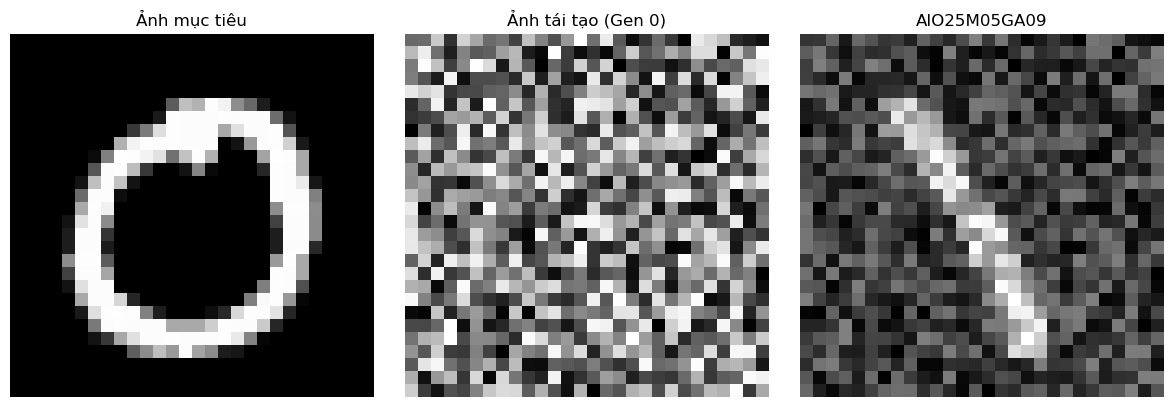

Gen 500 | Best MSE = 0.15139


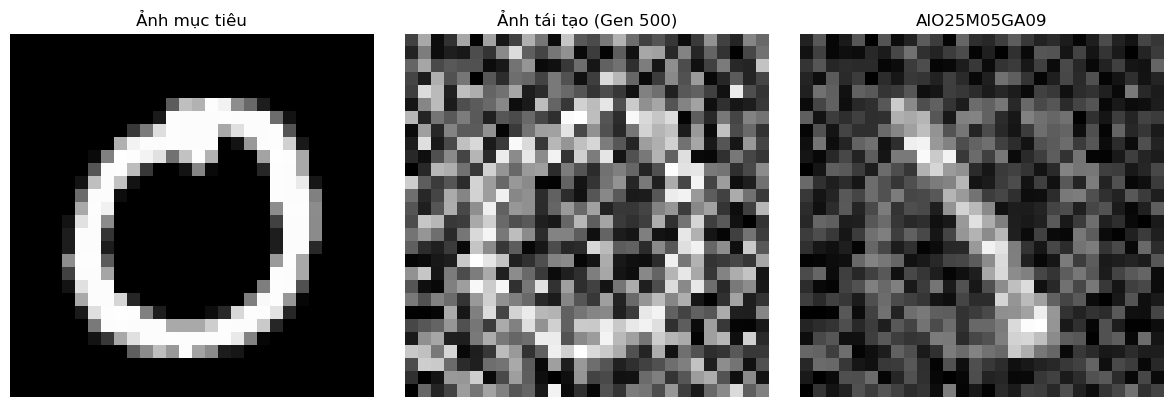

Gen 1000 | Best MSE = 0.10954


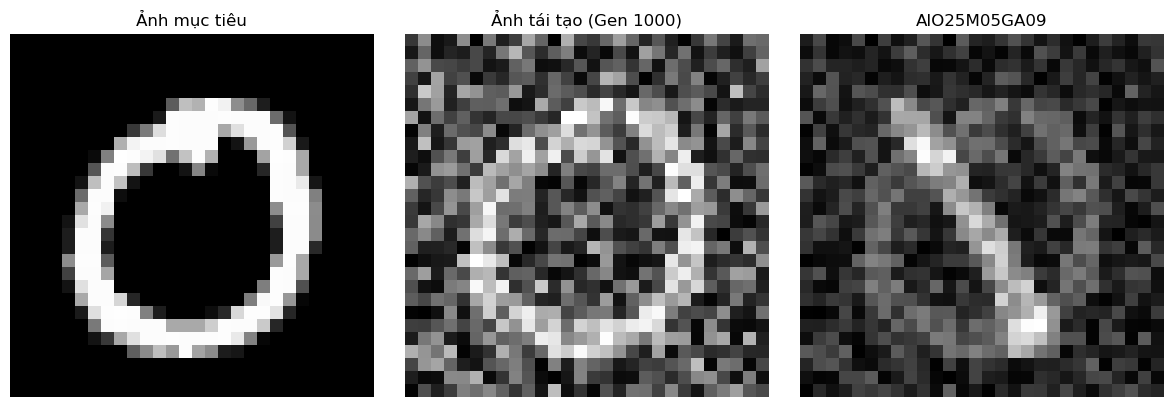

Gen 1500 | Best MSE = 0.07391


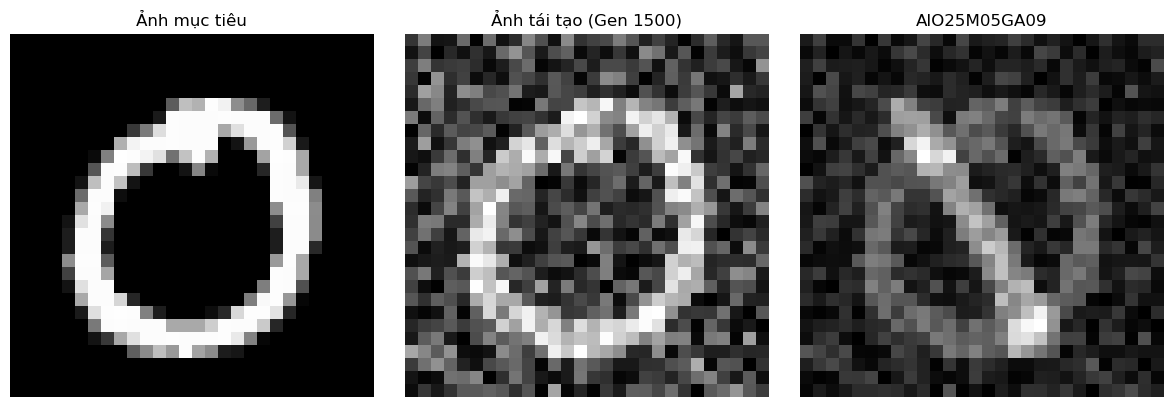

Gen 2000 | Best MSE = 0.04675


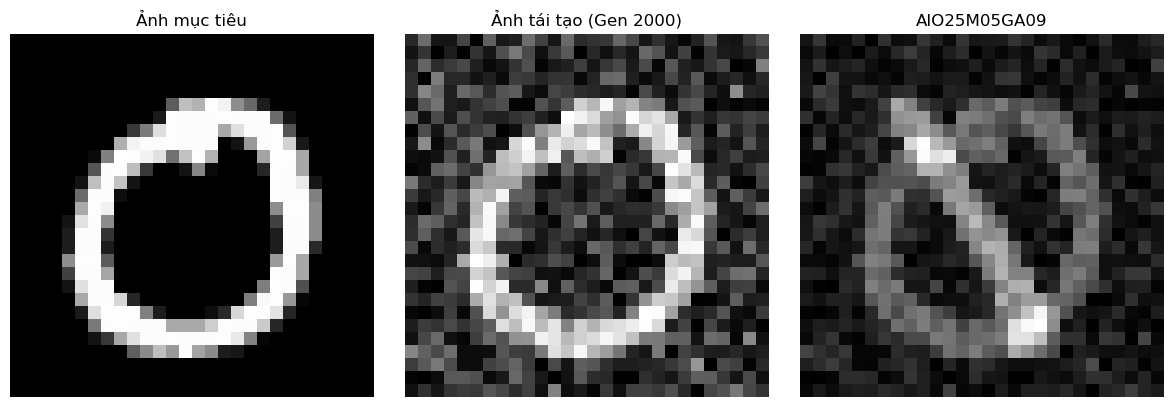

Gen 2500 | Best MSE = 0.02582


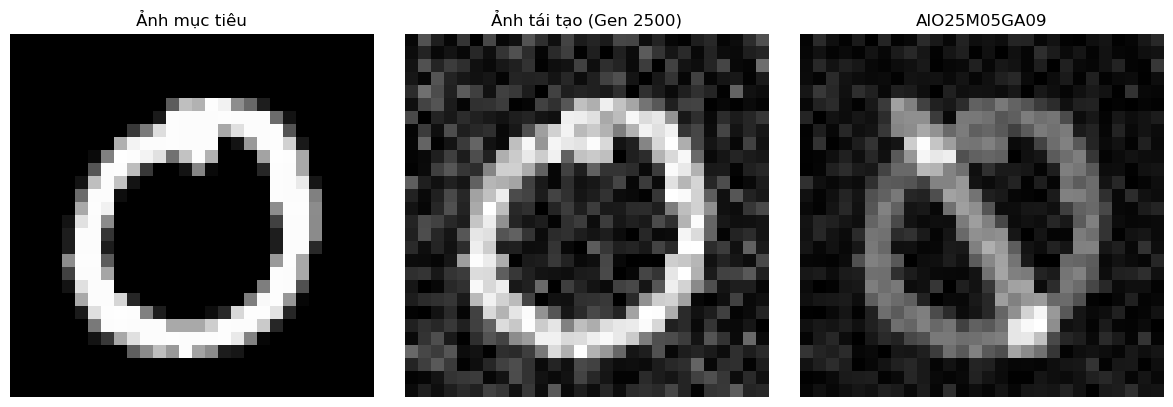

Gen 3000 | Best MSE = 0.01176


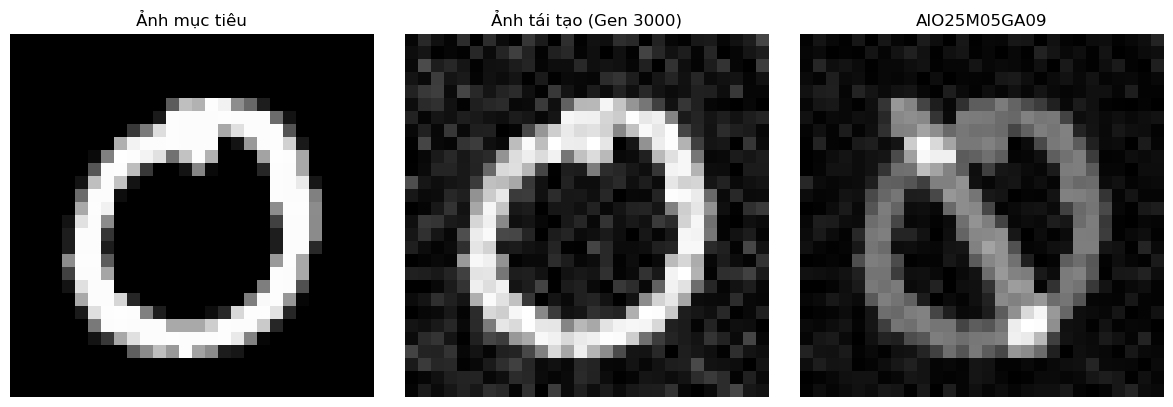

Gen 3500 | Best MSE = 0.00347


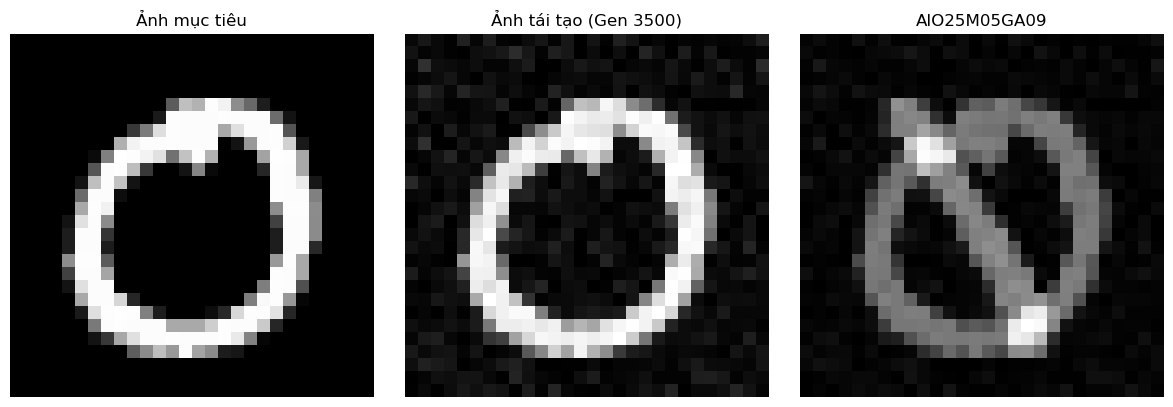

Gen 4000 | Best MSE = 0.00068


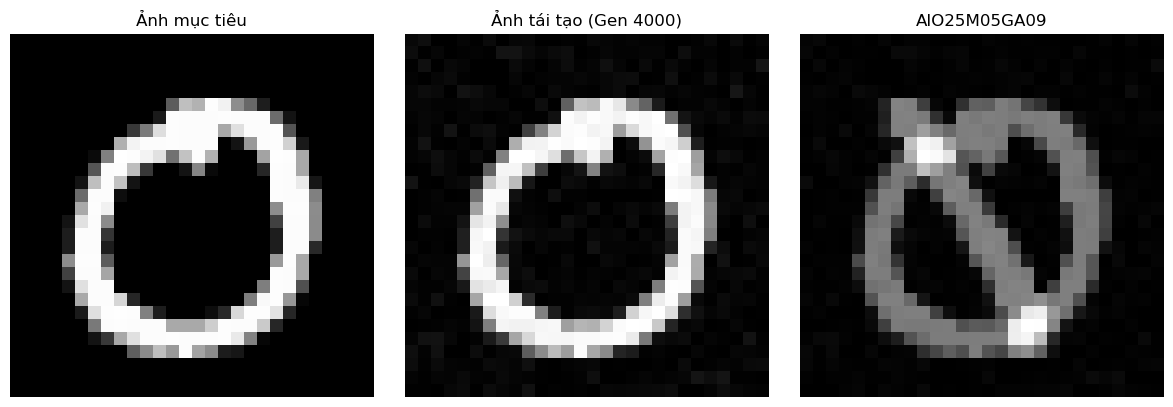

In [8]:
def evolve_reconstruction(target_vec, pop_size, generations, elitism):
    reset_seed(RANDOM_STATE)

    pop = init_population(pop_size, target_vec.size)
    losses = np.array([mse_loss(ind, target_vec) for ind in pop])
    fitnesses = np.array([fitness_from_mse(L) for L in losses])

    best_idx = int(np.argmin(losses))
    best_vec = pop[best_idx].copy()
    best_loss = float(losses[best_idx])
    history = [best_loss]

    target_img = vec_to_img(target_vec)
    print(f"Gen 0 | Best MSE = {best_loss:.5f}")
    plot_generation_snapshot(0, target_img, best_vec)

    for gen in range(generations):  # Vòng lặp cho mỗi thế hệ
        new_pop = []
        if elitism > 0:  # Giữ cá thể ưu tú
            new_pop.append(best_vec.copy())

        while len(new_pop) < pop_size:  # Lặp lại nếu chưa đủ cá thể cho quần thể mới
            parent1 = tournament_select(pop, fitnesses)  # your code: selection #1
            parent2 = tournament_select(pop, fitnesses)  # your code: selection #2
            c1, c2 = uniform_crossover(parent1, parent2)  # your code: crossover
            c1 = gaussian_mutation(c1)  # your code: mutation #1
            if len(new_pop) < pop_size - 1:
                c2 = gaussian_mutation(c2) # your code: mutation #2
                new_pop.extend([c1, c2])  # Thêm 2 cá thể vào quần thể mới
            else:
                new_pop.append(c1)  # Chỉ thêm cá thể đầu nếu đã đủ số lượng cho quần thể mới

        pop = np.array(new_pop[:pop_size])
        losses = np.array([mse_loss(ind, target_vec) for ind in pop])
        fitnesses = np.array([fitness_from_mse(L) for L in losses])

        gen_best_idx = int(np.argmin(losses))
        gen_best_loss = float(losses[gen_best_idx])
        if gen_best_loss < best_loss:
            best_loss = gen_best_loss
            best_vec = pop[gen_best_idx].copy()
        history.append(best_loss)

        if (gen+1) % 500 == 0 or gen == generations - 1:
            print(f"Gen {gen+1} | Best MSE = {best_loss:.5f}")
            plot_generation_snapshot(gen+1, target_img, best_vec)

    return best_vec, np.array(history), best_loss

best_vec, history, best_mse = evolve_reconstruction(target_vec, pop_size=pop_size, generations=generations, elitism=elitism)


## 6.Đánh giá

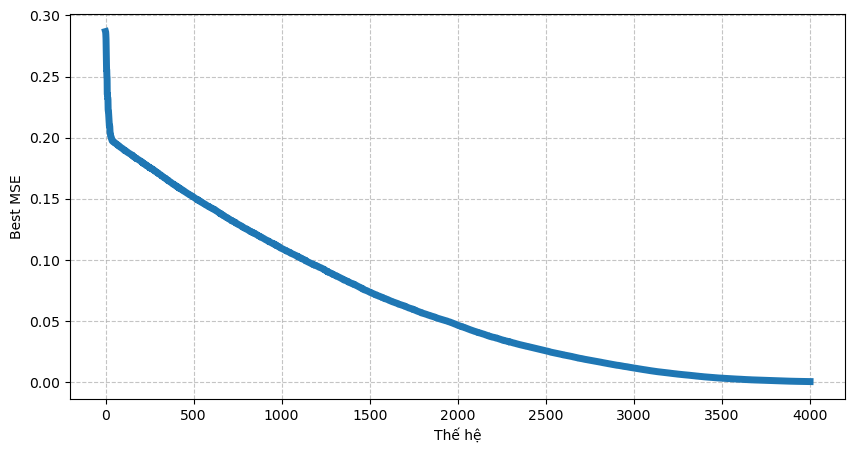

In [9]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(history)), history, linewidth=5)
plt.xlabel('Thế hệ')
plt.ylabel('Best MSE')
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('best_mse.png', dpi=300, bbox_inches='tight')
plt.show()